In [144]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import label_binarize


## Current Model Performance: **51.1%** Win Rate on Overs at Halftime

Percentages:
 total_win
0.0    48.824593
1.0    51.175407
Name: proportion, dtype: float64


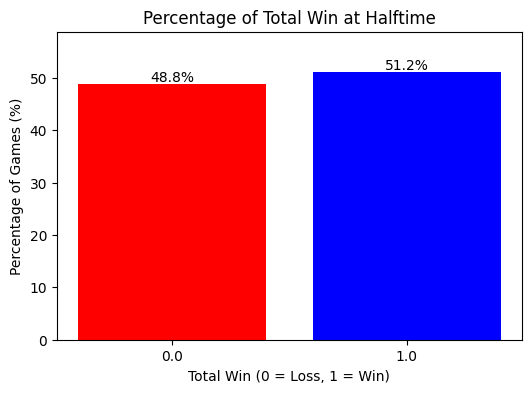

In [145]:
# Load your data
halftime_df = pd.read_csv("~/nfl_halftime_features_total.csv")

# Percentages
percent = halftime_df['total_win'].value_counts(normalize=True).sort_index() * 100
print("Percentages:\n", percent)

# Plotting percentages
plt.figure(figsize=(6,4))
plt.bar(percent.index.astype(str), percent.values, color=['red','blue'])
plt.xlabel('Total Win (0 = Loss, 1 = Win)')
plt.ylabel('Percentage of Games (%)')
plt.title('Percentage of Total Win at Halftime')
for i, v in enumerate(percent.values):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha='center', fontsize=10)
plt.ylim(0, max(percent.values)*1.15)  # add some space for text above bars
plt.show()



## Examine relationship between continuous features and over/under outcomes at Halftime

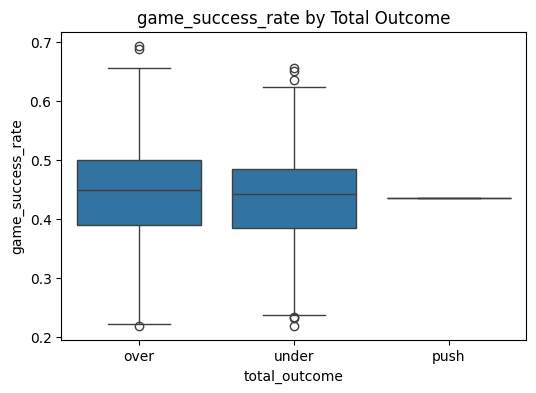

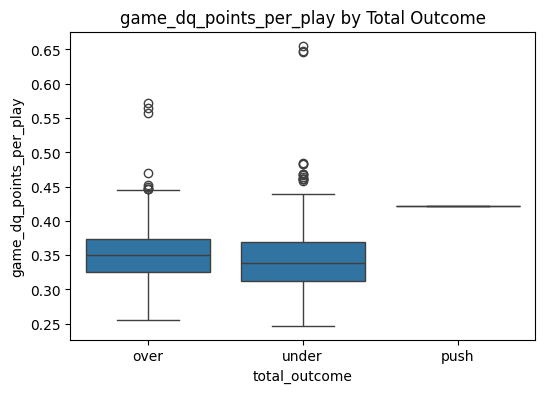

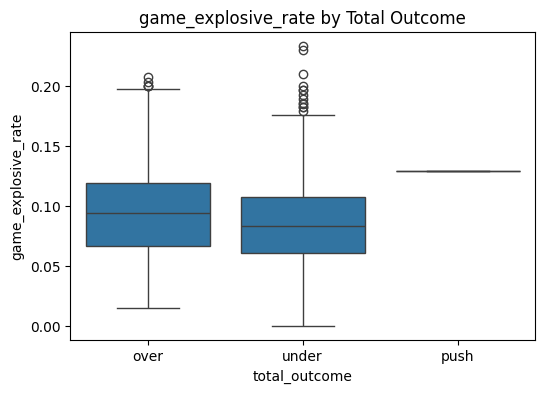

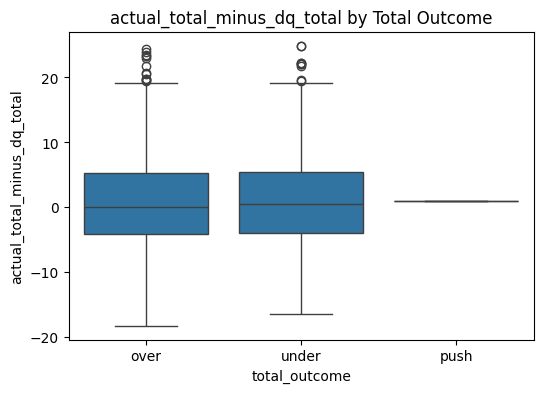

In [146]:
# get all columns from halftime df except for the target variable
continuous_vars = halftime_df.drop(columns=["total_outcome", "total_win", "game_id", "game_date"])

for col in continuous_vars:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='total_outcome', y=col, data=halftime_df)
    plt.title(f'{col} by Total Outcome')
    plt.show()

## Examine distribution of continuous variables in relation to binary outcome

/var/folders/xt/tmf1146d7290zvg92b_crg080000gn/T/ipykernel_83079/1902966781.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=halftime_df, x=col, hue='total_outcome', shade=True)
/var/folders/xt/tmf1146d7290zvg92b_crg080000gn/T/ipykernel_83079/1902966781.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=halftime_df, x=col, hue='total_outcome', shade=True)


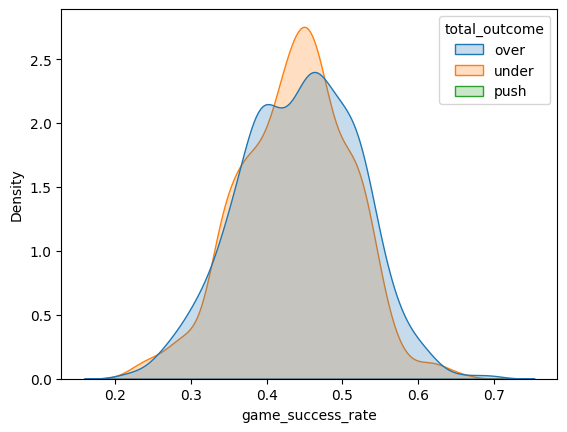

/var/folders/xt/tmf1146d7290zvg92b_crg080000gn/T/ipykernel_83079/1902966781.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=halftime_df, x=col, hue='total_outcome', shade=True)
/var/folders/xt/tmf1146d7290zvg92b_crg080000gn/T/ipykernel_83079/1902966781.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=halftime_df, x=col, hue='total_outcome', shade=True)


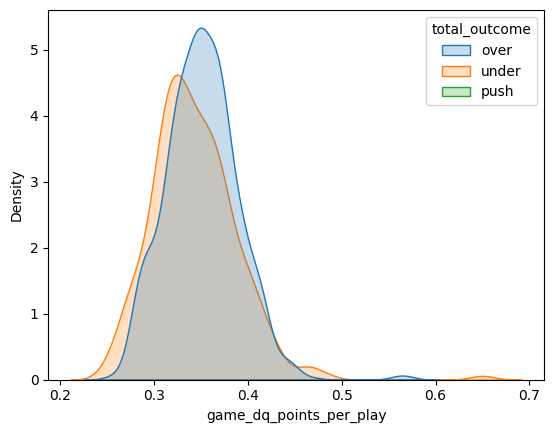

/var/folders/xt/tmf1146d7290zvg92b_crg080000gn/T/ipykernel_83079/1902966781.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=halftime_df, x=col, hue='total_outcome', shade=True)
/var/folders/xt/tmf1146d7290zvg92b_crg080000gn/T/ipykernel_83079/1902966781.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=halftime_df, x=col, hue='total_outcome', shade=True)


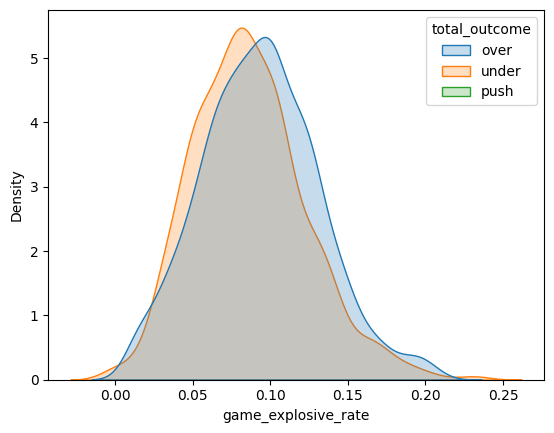

/var/folders/xt/tmf1146d7290zvg92b_crg080000gn/T/ipykernel_83079/1902966781.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=halftime_df, x=col, hue='total_outcome', shade=True)
/var/folders/xt/tmf1146d7290zvg92b_crg080000gn/T/ipykernel_83079/1902966781.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=halftime_df, x=col, hue='total_outcome', shade=True)


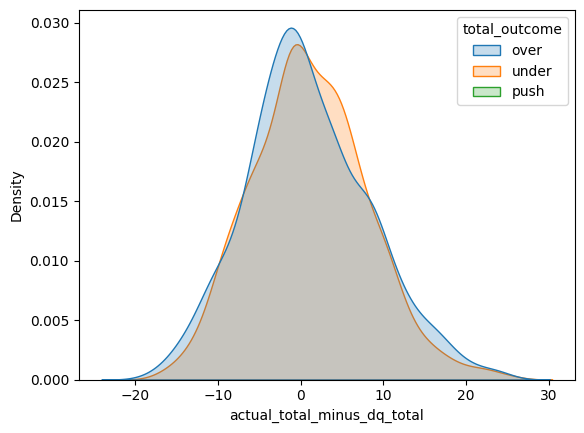

In [147]:
for col in continuous_vars:
    sns.kdeplot(data=halftime_df, x=col, hue='total_outcome', shade=True)
    plt.show()


## Examine Distribution of Each Variable (All Normally Distributed)

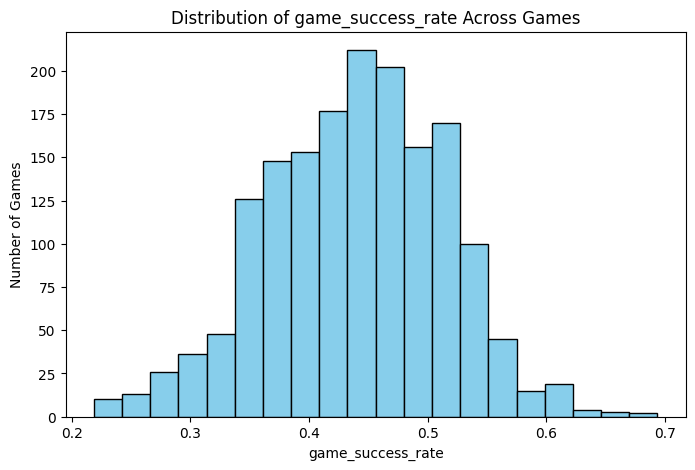

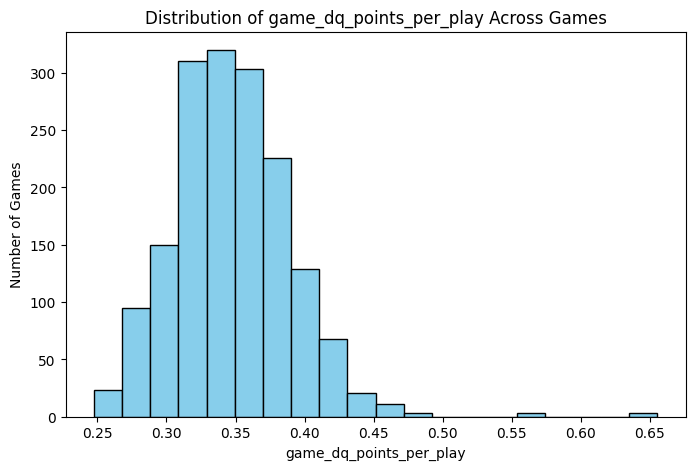

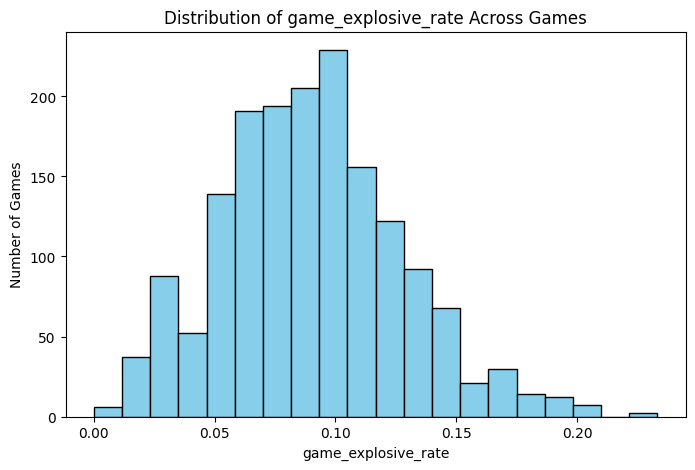

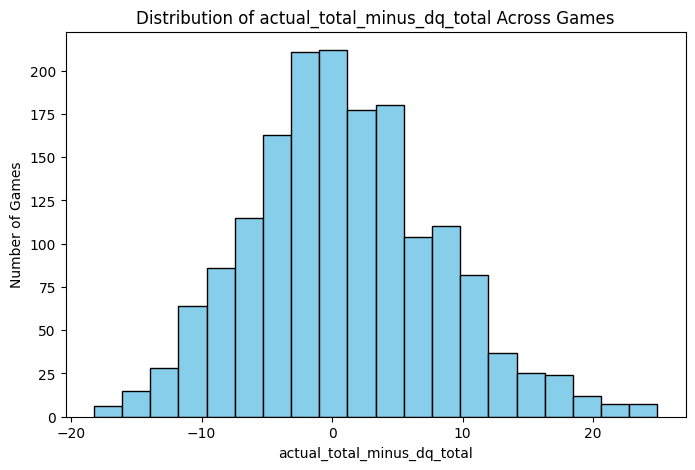

In [148]:
for col in continuous_vars:
    plt.figure(figsize=(8,5))
    plt.hist(halftime_df[col], bins=20, color='skyblue', edgecolor='black')
    plt.xlabel(col)
    plt.ylabel("Number of Games")
    plt.title(f"Distribution of {col} Across Games")
    plt.show()


## Train Logistic Regression Model to Predict Over/Under Outcome at Halftime with Each of Continous Features and Examine Relationship

In [149]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

# Encode target
y = halftime_df['total_outcome'].map({'under':0, 'over':1})

# To store results
results = []

for col in continuous_vars:
    # Prepare data
    data = halftime_df[['game_date', col]].copy()
    data['target'] = y
    data = data.dropna()

    # Sort by game_date to avoid data leakage
    data = data.sort_values('game_date')

    X = data[[col]].values  # as array for scaler
    y_clean = data['target']

    # Normalize variable
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Chronological train-test split (e.g., 80% train, 20% test)
    split_idx = int(len(data) * 0.8)
    X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
    y_train, y_test = y_clean.iloc[:split_idx], y_clean.iloc[split_idx:]

    # Logistic regression
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Predict probabilities
    y_proba = model.predict_proba(X_test)[:,1]

    # Store results
    results.append({
        'feature': col,
        'coefficient': model.coef_[0][0],
        'intercept': model.intercept_[0],
        'roc_auc': roc_auc_score(y_test, y_proba)
    })

# Convert to DataFrame and rank by ROC AUC
results_df = pd.DataFrame(results).sort_values(by='roc_auc', ascending=False)
print(results_df)


                       feature  coefficient  intercept   roc_auc
3  actual_total_minus_dq_total    -0.007331  -0.093328  0.494077
2          game_explosive_rate     0.240297  -0.096716  0.468694
1      game_dq_points_per_play     0.210756  -0.068647  0.466190
0            game_success_rate     0.182254  -0.104305  0.454840


## Examine Correlation between Features to Ensure We aren't Double Counting

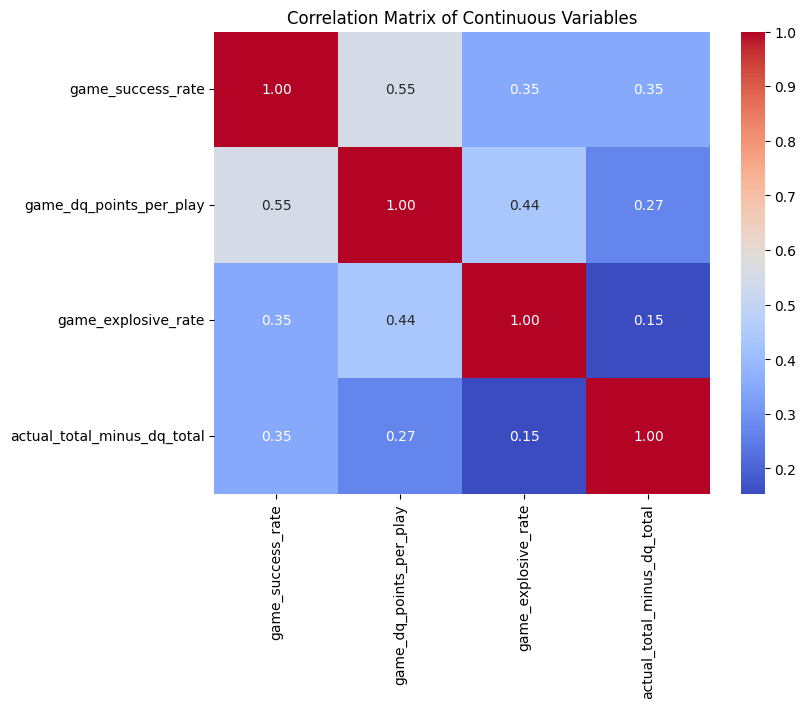

In [150]:
# Compute correlation matrix
corr_matrix = continuous_vars.corr()

# Visualize with a heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Continuous Variables")
plt.show()


## New Logistic Regression Model: **55.1%** Win Rate

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.49      0.51       162
           1       0.56      0.61      0.58       170

    accuracy                           0.55       332
   macro avg       0.55      0.55      0.55       332
weighted avg       0.55      0.55      0.55       332

Confusion Matrix:
[[ 79  83]
 [ 66 104]]
Accuracy: 0.5512048192771084

Feature Importance:
                       feature  coefficient  abs_coefficient
2          game_explosive_rate     0.191640         0.191640
1      game_dq_points_per_play     0.185002         0.185002
0            game_success_rate    -0.068720         0.068720
3  actual_total_minus_dq_total    -0.041556         0.041556


/var/folders/xt/tmf1146d7290zvg92b_crg080000gn/T/ipykernel_83079/1029904154.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='abs_coefficient', y='feature', data=feature_importance, palette='viridis')


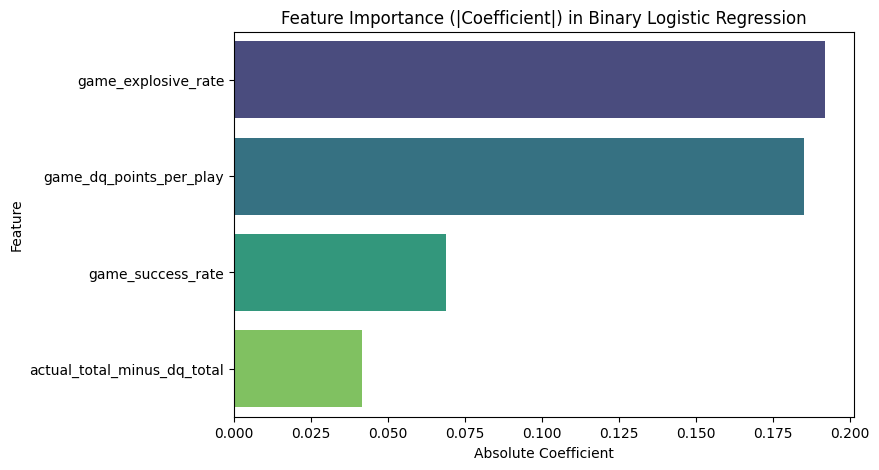

In [151]:
# Filter out 'push' class
filtered_idx = halftime_df['total_outcome'].isin(['over','under'])
X = continuous_vars.loc[filtered_idx].copy()   # only rows corresponding to over/under

y = halftime_df.loc[filtered_idx, 'total_outcome'].map({'under':0, 'over':1})

# Drop rows with NaNs
X = X.dropna()
y = y.loc[X.index]  # now X and y have matching indices

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Logistic regression
model = LogisticRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

# Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_[0],
    'abs_coefficient': abs(model.coef_[0])
}).sort_values(by='abs_coefficient', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(8,5))
sns.barplot(x='abs_coefficient', y='feature', data=feature_importance, palette='viridis')
plt.title("Feature Importance (|Coefficient|) in Binary Logistic Regression")
plt.xlabel("Absolute Coefficient")
plt.ylabel("Feature")
plt.show()


## XGBoost Model: 73.8% Win Rate

/Users/camerongleichauf/ShotQuality/exploratory-data-notebooks/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:59:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/var/folders/xt/tmf1146d7290zvg92b_crg080000gn/T/ipykernel_83079/4038128474.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_xgb, palette='viridis')


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.74      0.73       162
           1       0.75      0.74      0.74       170

    accuracy                           0.74       332
   macro avg       0.74      0.74      0.74       332
weighted avg       0.74      0.74      0.74       332

XGBoost Confusion Matrix:
[[120  42]
 [ 45 125]]
XGBoost Accuracy: 0.7379518072289156

XGBoost Feature Importance:
                       feature  importance
1      game_dq_points_per_play    0.275314
0            game_success_rate    0.243662
2          game_explosive_rate    0.240785
3  actual_total_minus_dq_total    0.240239


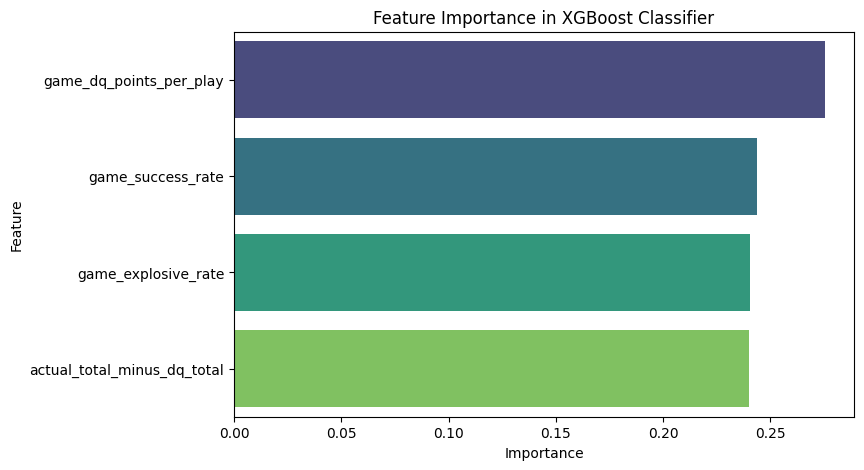

In [152]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Train XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:,1]

# Evaluation
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("XGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))

# Feature importance
importance = xgb_model.feature_importances_
feature_importance_xgb = pd.DataFrame({
    'feature': X.columns,
    'importance': importance
}).sort_values(by='importance', ascending=False)

print("\nXGBoost Feature Importance:")
print(feature_importance_xgb)

# Plot feature importance
plt.figure(figsize=(8,5))
sns.barplot(x='importance', y='feature', data=feature_importance_xgb, palette='viridis')
plt.title("Feature Importance in XGBoost Classifier")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


## Interpretation

The most predictive feature in the XGBoost Classifier we trained was the DQ points/per play. This aligns with what we have heard from a syndicate that backtested our data as well. The win rate of 73.4% is significantly higher for XGBoost than Logistic Regression, which reflects the non-linear relationship between the variables and XGBoost's ability to encapsulate these complex, non-linear relationships much better than a linear model. 

## Final Decision

Since game DQ points per play had the largest feature importance and we want to make drastic changes all at once in production, we'll start by replacing raw DQ points with DQ points/play when projecting live spread/live total. 